In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
import seaborn as sns
import omega_index
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *

In [2]:
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
#oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable

## input format: 
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x

def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    ctr = 1
    for nm in names:
        if ctr%1000==0:
            print(ctr)
        ctr+=1
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


## Testing - keep only some communities


In [68]:
## read data
with open('../Datasets/DBLPFull.pkl', 'rb') as handle:
    b = pickle.load(handle)
Communities = b["Community lists"][:-1]
Edges = b['edges'][:-1]


# number of comms
print('number of GT communities:',len(Communities))

# community sizes
print('most common community sizes:')
print(Counter([len(x) for x in Communities]).most_common(10))

# number of edges
print('\nnumber of edges:',len(Edges))
G = ig.Graph.TupleList([tuple(e) for e in Edges])

# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}
print('number of nodes:',G.vcount(),'\n')


number of GT communities: 13477
most common community sizes:
[(6, 3680), (7, 2195), (8, 1461), (9, 1005), (10, 747), (11, 564), (12, 391), (13, 310), (14, 244), (16, 204)]

number of edges: 1049866
number of nodes: 317080 



In [69]:
## top 
with open('com-dblp.top5000.cmty.txt') as file:
    lines = [line.rstrip() for line in file]
Communities = []
for L in lines:
    Communities.append([int(x) for x in L.split('\t')])


In [71]:
#Comms = [C for C in Communities if len(C)>=100 and len(C)<=150]
Comms = Communities
# store all communities for each node
for v in G.vs:
    v['comms'] = []
## append communities in 1-based format (we keep 0 for the outliers - no communities)
for i in range(len(Comms)):
    for v in Comms[i]:
        G.vs[v_dct[v]]['comms'].append(i+1)
G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
print('Number of memberships (most frequent):')
print(Counter(G.vs['n_comms']).most_common(10), '\n')


Number of memberships (most frequent):
[(0, 223648), (1, 79535), (2, 10546), (3, 2307), (4, 716), (5, 225), (6, 59), (7, 26), (8, 12), (9, 4)] 



In [72]:
G.vs['name'] = [str(x) for x in G.vs['name']]
V = np.where(np.array(G.vs['n_comms'])==0)[0]
G.delete_vertices(V)
G = G.connected_components().giant()
G.delete_vertices(np.where(np.array(G.coreness()) <2)[0])
G.vcount()


84973

In [73]:
print(Counter(G.vs['n_comms']).most_common(10), '\n')


[(1, 71276), (2, 10369), (3, 2290), (4, 710), (5, 225), (6, 59), (7, 26), (8, 12), (9, 4), (12, 1)] 



In [74]:
## Compute the external edge fraction given communities for each node
C = Counter([len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms'])))>0 for e in G.es])
print('xi_hat =',C[0]/(C[0]+C[1]))


xi_hat = 0.08563692032518305


In [75]:
# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}
print('number of nodes:',G.vcount(),'\n')


number of nodes: 84973 



In [76]:
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)


In [99]:
x = mems2comms(G.vs['comms'])[1:]
GT = [i for i in x if len(i)>1]
len(GT)

4559

In [100]:
max(G.vs['leiden'])

236

In [97]:
for th in [.25]:
    L = []
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            L.append(list(x))    


In [98]:
compute_oNMI(GT,L)

0.0379851

In [101]:
%%time
ES = EgoSplit(G, algo='ECG')
with open('es_subset.pkl','wb') as fp:
    pickle.dump(ES,fp)


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
CPU times: user 2h 36min 31s, sys: 12.5 s, total: 2h 36min 44s
Wall time: 2h 36min 59s


In [102]:
min_size = 10
X = [list(x) for x in ES if len(x)>=min_size]    
ego = [ [v_dct[i] for i in j] for j in X ]
compute_oNMI(GT,ego)


0.111462

In [103]:
C = sparse.csc_matrix((G.vcount(),len(ego)))
C.indices = np.array([int(i) for j in ego for i in j])
C.data = np.repeat(1,len(C.indices))
ptr = [0]
ctr = 0
for x in ego:
    ctr += len(x)
    ptr.append(ctr)
C.indptr = np.array(ptr)
M = C.tocsr()


In [106]:
IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), M, alpha=1)
for th in np.arange(.3,.5,.01):
    L = []
    for i in range(Beta.shape[1]):
        x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th))[0]
        if len(x)>0:
            L.append(list(x))    
    print(th,compute_oNMI(GT,L))

0.3 0.106304
0.31 0.106215
0.32 0.105739
0.33 0.105688
0.34 0.111112
0.35000000000000003 0.110714
0.36000000000000004 0.110623
0.37000000000000005 0.110372
0.38000000000000006 0.110114
0.39000000000000007 0.109808
0.4000000000000001 0.109876
0.4100000000000001 0.109795
0.4200000000000001 0.109712
0.4300000000000001 0.10951
0.4400000000000001 0.109382
0.4500000000000001 0.109152
0.46000000000000013 0.108587
0.47000000000000014 0.108121
0.48000000000000015 0.107424
0.49000000000000016 0.107408


## top communities (up to 5000)

In [30]:
## read data
with open('../Datasets/DBLPFull.pkl', 'rb') as handle:
    b = pickle.load(handle)
Communities = b["Community lists"][:-1]
Edges = b['edges'][:-1]


# number of comms
print('number of GT communities:',len(Communities))

# community sizes
print('most common community sizes:')
print(Counter([len(x) for x in Communities]).most_common(10))

# number of edges
print('\nnumber of edges:',len(Edges))
G = ig.Graph.TupleList([tuple(e) for e in Edges])

# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}
print('number of nodes:',G.vcount(),'\n')


number of GT communities: 13477
most common community sizes:
[(6, 3680), (7, 2195), (8, 1461), (9, 1005), (10, 747), (11, 564), (12, 391), (13, 310), (14, 244), (16, 204)]

number of edges: 1049866
number of nodes: 317080 



In [34]:
G.vs[0]

igraph.Vertex(<igraph.Graph object at 0x103824e50>, 0, {'name': 0})

In [32]:
TopComs

[['105653', '105654', '210737', '210738', '210739', '211813', '211814'],
 ['53599',
  '69449',
  '115973',
  '135447',
  '198973',
  '231501',
  '258663',
  '258664',
  '258878',
  '258879',
  '258880',
  '258881',
  '258882',
  '258883',
  '268226',
  '273534',
  '278033',
  '278127',
  '284825'],
 ['14320',
  '24722',
  '26240',
  '44769',
  '45169',
  '57357',
  '75878',
  '87447',
  '100480',
  '107928',
  '128723',
  '130891',
  '130893',
  '145212',
  '145213',
  '146090',
  '147152',
  '147153',
  '147154'],
 ['12083', '21358', '21719', '21916', '21917', '21918'],
 ['6880', '6881', '6882', '6883', '6884', '6885'],
 ['66911', '66913', '66915', '102533', '178107', '332128', '339068', '339069'],
 ['77916', '147731', '150907', '315669', '339888', '370497', '370498'],
 ['114450', '114451', '115429', '115430', '141941', '148107'],
 ['52201',
  '67186',
  '128284',
  '141315',
  '144846',
  '167358',
  '231852',
  '234813',
  '237994',
  '239688',
  '248515',
  '265386',
  '299756',
  

In [20]:
with open('com-dblp.top5000.cmty.txt') as file:
    lines = [line.rstrip() for line in file]
TopComs = []
for L in lines:
    TopComs.append([int(x) for x in L.split('\t')])


In [58]:
v = set([x for y in TopComs[:100] for x in y])
V = [G.vs.find(name=x) for x in v]
V

[igraph.Vertex(<igraph.Graph object at 0x103824e50>, 212499, {'name': 296962}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 153187, {'name': 141315}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 23469, {'name': 151555}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 11898, {'name': 296963}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 212500, {'name': 296964}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 304458, {'name': 301063}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 303096, {'name': 417800}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 212501, {'name': 296965}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 212502, {'name': 296966}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 224675, {'name': 325643}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 237920, {'name': 315404}),
 igraph.Vertex(<igraph.Graph object at 0x103824e50>, 86844, {'name': 57357}),
 igraph.Vertex(<igraph.Graph object at 0x103

In [59]:
SG = G.subgraph(V)

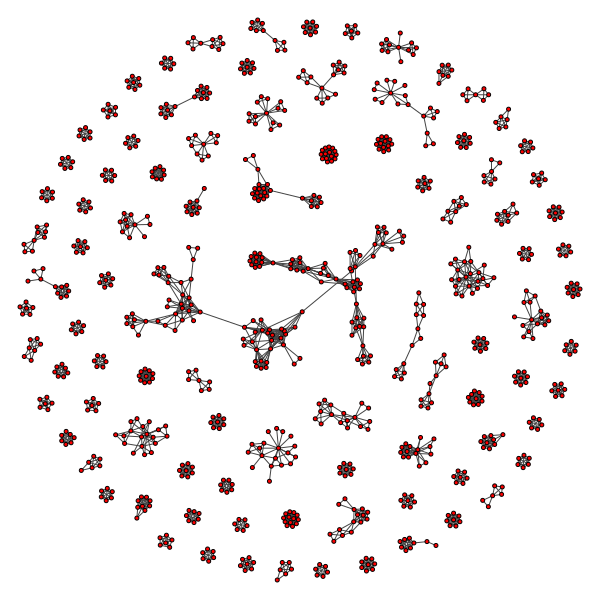

In [67]:
ig.plot(SG, vertex_size=4)